# Parameter Identifiability

In [47]:
import pandas
from Code.PK_model import PintsPKLinIV as Pints_PK_model
from Code.PD_model import PintsPDFribergLinE as Pints_PD_model
from Code.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood
import pints
import nlopt
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


image_file = "../Images/parameter_identifiability/"

In [2]:
drug = 'Docetaxel'
dose = 10.0
num_comp = 2
observation_name = 'Platelets '

### Example

## Simulated Data

In [3]:
PD_actual_params = np.load("../Data_and_parameters/PD_sim/actual_params_dose_2.npy")
PD_param_names = ["C_cell_0", "MTT", "gamma", "s", "sigma_base", "eta", "sigma_rel"]
print("Parameters used for simulated data:")
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(PD_actual_params[i]))

Parameters used for simulated data:
C_cell_0 = 983.1
MTT = 85.26
gamma = 0.44
s = 20.0
sigma_base = 42.43
eta = 1.0
sigma_rel = 0.13


In [4]:
PK_params=np.load("../Data_and_parameters/PK_sim/actual_params_dose_2.npy")[:-1]

df = pandas.read_csv("../Data_and_parameters/PD_sim/sythesised_data_real_timepoints.csv")
start_time = df['TIME'].min()
dose_amount=2.0

print(df)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = np.mean(df_before_0["OBS"])
print("approximate Circ_0: ", Circ_0_approx)

     TIME          OBS
0   -48.0   855.328230
1    24.0  1026.264581
2    48.0   871.865095
3    72.0   660.206610
4    96.0   581.442512
5   120.0   475.124656
6   144.0   796.647858
7   168.0   513.728347
8   192.0   997.665363
9   216.0   959.121053
10  240.0  1402.868099
11  264.0  1472.195855
12  288.0  1873.293319
13  312.0  1357.996620
14  336.0  1523.421688
15  360.0   785.629870
16  384.0   855.026692
17  432.0   870.378293
18  480.0   692.746295
19  552.0   945.146789
approximate Circ_0:  855.328230384973


In [5]:
opt_df = pandas.read_csv("../Data_and_parameters/PD_sim/opt_results.csv")
opt_point_comb = np.asarray(opt_df['Combined Noise'][1:-1])
opt_point_comb = opt_point_comb.astype(float)

lower_bound = [0.1*Circ_0_approx, df['TIME'].max()*0.001, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*Circ_0_approx,      df['TIME'].max(),     5,    100,   Circ_0_approx,   10,    1]

print('Initial point for profile likelihood')
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(opt_point_comb[i]))

Initial point for profile likelihood
C_cell_0 = 967.9164190565756
MTT = 80.50017091539418
gamma = 0.43337261276858063
s = 24.676329686612924
sigma_base = 92.95909333203048
eta = 1.5833303067488664
sigma_rel = 0.0010000000000487134


In [6]:
algorithm = nlopt.LN_BOBYQA
num_param = len(opt_point_comb)-1
base_opt = nlopt.opt(algorithm, num_param)
base_opt.set_lower_bounds([0]*num_param)
unchanged_threshold = 1e-4
base_opt.set_ftol_abs(unchanged_threshold)
base_opt.set_xtol_rel(1e-4)
timer = pints.Timer()

def single_profile_loglikelihood(param_index, param_values, point_start):
    likelihood = []
    jump_points = []
    jump_hu = {}
    point = point_start
    previous_loglike = 0
    lb = base_opt.get_lower_bounds()
    ub = base_opt.get_upper_bounds()
    
    for i, x_i in enumerate(param_values):
        
        fix_noise = [None]*3

        if param_index < 4:
            fix_param=[[param_index], [x_i]]
        else:
            fix_param=[[], []]
            fix_noise[param_index-4] = x_i

        pints_model_simulated = Pints_PD_model(
            PK_params, 
            dose_amount, 
            fix_param=fix_param, 
            start_time=start_time
        )
        problem = pints.SingleOutputProblem(
            pints_model_simulated, 
            df['TIME'].to_numpy()-start_time, 
            df['OBS'].to_numpy()
        )
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)
        
        def obj_func(x, grad):
            time_stamp = timer.time()
            print(
                "\r", 
                str(np.round((i/len(param_values)+n), 2)*50)
                + "% complete, time elapsed: "
#                 + str(int(time_stamp/60.0)) + " mins, "
#                 + str(time_stamp%60) + " secs.  ",
                + timer.format(timer.time()),
                sep=' ', 
                end='', 
                flush=True
            )
            return log_likelihood(x)
        
        opt = nlopt.opt(base_opt)
        opt.set_max_objective(obj_func)
        
        if any(point <= lb):
            for point_index in range(len(point)):
                point[point_index] = max(point[point_index], 1.0001*lb[point_index])
        if any(point >= ub):
            for point_index in range(len(point)):
                point[point_index] = min(point[point_index], 0.9999*ub[point_index])
                
        point = opt.optimize(point)
        loglike = opt.last_optimum_value()
        likelihood.append([x_i, loglike])
#         if abs(loglike - previous_loglike) > (3.84/2):
#             jump_points.append([x_i, point, loglike])
# #             jump_hu [x_i] = pints_model_simulated.hu
#         previous_loglike = loglike
#     if jump_points != []:
#         np.save(
#             "./Data_and_parameters/Debugging/identify_comb_jumps_param_"+str(param_index)+"_n_"+str(n), 
#             jump_points
#         )
#         np.save(
#             "./Data_and_parameters/Debugging/identify_comb_hus_param_"+str(param_index)+"_n_"+str(n), 
#             jump_hu
#         )
    return(likelihood)

In [30]:
# Mechanistic parameters

for param_index in range(0, 4): # upto param no. 4
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:]))
    base_opt.set_lower_bounds(lower_bound[:param_index] + lower_bound[param_index+1:])
    base_opt.set_upper_bounds(upper_bound[:param_index] + upper_bound[param_index+1:])
    
    timer.reset()
    
    n=0
    param_range = np.linspace(1*opt_point_comb[param_index], 0.5*opt_point_comb[param_index], 100)
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, point)
    
    n+=1
    param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
    likelihood_lower.reverse()
    likelihood = np.array(likelihood_lower+likelihood_upper)
    np.save("../Data_and_parameters/PD_sim/identify_comb_param_"+str(param_index), likelihood)


 Profile likelihood for Circ_0:
 50.0% complete, time elapsed: 7 mins, 8.052426205947995 secs.      96 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



 99.5% complete, time elapsed: 13 mins, 44.853015718981624 secs.    17 secs.    

In [12]:
# Noise parameters
for param_index in range(4, 7): # param no. 4 to 7
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    # This should be done on a log scale across the prior
    
    point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:]))
    base_opt.set_lower_bounds(lower_bound[:param_index] + lower_bound[param_index+1:])
    base_opt.set_upper_bounds(upper_bound[:param_index] + upper_bound[param_index+1:])
    timer.reset()
    
    tot_evals = 200
    proportion = (
        np.log(opt_point_comb[param_index])-np.log(lower_bound[param_index])
    )/(
        np.log(upper_bound[param_index]) - np.log(lower_bound[param_index])
    )
    
    n=0
    param_range = np.logspace(np.log(opt_point_comb[param_index]), np.log(lower_bound[param_index]), int(tot_evals*proportion), base = np.e)
    
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, point)
    
    n+=1
    param_range = np.logspace(np.log(opt_point_comb[param_index]), np.log(upper_bound[param_index]), tot_evals-int(tot_evals*proportion), base = np.e)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
    likelihood_lower.reverse()
    likelihood = np.array(likelihood_lower+likelihood_upper)
    np.save("../Data_and_parameters/PD_sim/identify_comb_param_"+str(param_index)+"_log_scale", likelihood)


 Profile likelihood for eta:
 99.0% complete, time elapsed: 15 minutes, 49 secondss, 9 secondss
 Profile likelihood for sigma_rel:
 100.0% complete, time elapsed: 16 minutes, 33 seconds 44 seconds

In [30]:
algorithm = nlopt.LN_BOBYQA
num_param = len(opt_point_comb)-2
base_opt = nlopt.opt(algorithm, num_param)
base_opt.set_lower_bounds([0]*num_param)
unchanged_threshold = 1e-4
base_opt.set_ftol_abs(unchanged_threshold)
base_opt.set_xtol_rel(1e-4)
timer = pints.Timer()

def pair_profile_likelihood(param_index_1, param_index_2, param_values_1, param_values_2, point_start):
    point_next_line = point_start
    likelihood_matrix = np.zeros((len(param_values_1), len(param_values_2)))
    lb = base_opt.get_lower_bounds()
    ub = base_opt.get_upper_bounds()
    
    for i, x_1 in enumerate(param_values_1):
        point = point_next_line
        
        for j, x_2 in enumerate(param_values_2):
            
            fix_mech = [[],[]]
            fix_noise = [None]*3
            if param_index_1<4:
                fix_mech[0].append(param_index_1)
                fix_mech[1].append(x_1)
            else: 
                fix_noise[param_index_1-4]=x_1
            if param_index_2<4:
                fix_mech[0].append(param_index_2)
                fix_mech[1].append(x_2)
            else: 
                fix_noise[param_index_2-4]=x_2
            
            
            pints_model_simulated = Pints_PD_model(
                PK_params, 
                dose_amount, 
                fix_param=fix_mech, 
                start_time=start_time
            )
            problem = pints.SingleOutputProblem(
                pints_model_simulated,
                df['TIME'].to_numpy()-start_time, 
                df['OBS'].to_numpy()
            )
            
            log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)  
            
            def obj_func(x, grad):
                time_stamp = timer.time()
                print(
                    "\r", 
                    str(np.round(((i+j/len(param_values_2))/len(param_values_1)+n)*25 , 2))
                    + "% complete, time elapsed: "
                    + str(int(time_stamp/60.0)) + " mins, "
                    + str(time_stamp%60) + " secs.  ",
                    sep=' ', 
                    end='', 
                    flush=True
                )
                return log_likelihood(x)
            
            opt = nlopt.opt(base_opt)
            opt.set_max_objective(obj_func)
            if any(point <= lb):
                for point_index in range(len(point)):
                    point[point_index] = max(point[point_index], 1.0001*lb[point_index])
            if any(point >= ub):
                for point_index in range(len(point)):
                    point[point_index] = min(point[point_index], 0.9999*ub[point_index])
                
            point = opt.optimize(point)
            loglike = opt.last_optimum_value()
            likelihood_matrix[i,j] = loglike
            
            if j==0:
                point_next_line = point
    return likelihood_matrix

In [34]:
# For double mechanistic parameters
for param_index_1 in range(0, 4):
    param_range_1_lower = np.linspace(1*opt_point_comb[param_index_1], 0.5*opt_point_comb[param_index_1], 10)
    param_range_1_upper = np.linspace(1*opt_point_comb[param_index_1], 1.5*opt_point_comb[param_index_1], 10)
    y_range = np.concatenate((param_range_1_lower[::-1], param_range_1_upper))
    
    for param_index_2 in range(0,param_index_1):
        print(
            "\n Pairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)

        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        x_range = np.concatenate((param_range_2_left[::-1], param_range_2_right))
    
        np.save(
            "./Data_and_parameters/PD_sim/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2), 
            (likelihood, x_range, y_range)
        )


 Pairwise Profile likelihood for MTT and Circ_0:
 99.75% complete, time elapsed: 44 mins, 53.12578889541328 secs.     
 Pairwise Profile likelihood for gamma and Circ_0:
 99.75% complete, time elapsed: 41 mins, 9.959124773740768 secs.      3.5% complete, time elapsed: 21 mins, 0.9391837473958731 secs.  53.5% complete, time elapsed: 21 mins, 1.647967653349042 secs.  53.5% complete, time elapsed: 21 mins, 3.3527732752263546 secs.  53.5% complete, time elapsed: 21 mins, 3.7596287429332733 secs.  97.5% complete, time elapsed: 40 mins, 22.65530633740127 secs.  
 Pairwise Profile likelihood for gamma and MTT:
 31.75% complete, time elapsed: 12 mins, 18.407800221815705 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



 99.75% complete, time elapsed: 31 mins, 39.2566152960062 secs.       
 Pairwise Profile likelihood for slope and Circ_0:
 99.75% complete, time elapsed: 60 mins, 2.371432011947036 secs.      70.0% complete, time elapsed: 46 mins, 15.577834241092205 secs.  
 Pairwise Profile likelihood for slope and MTT:
 99.75% complete, time elapsed: 52 mins, 49.091498816385865 secs.     
 Pairwise Profile likelihood for slope and gamma:
 99.75% complete, time elapsed: 35 mins, 33.06585983373225 secs.     

In [13]:
# For one mechanistic parameter and one noise parameter
for param_index_1 in range(5, 7):
    
    tot_evals = 20
    proportion_1 = (
        np.log(opt_point_comb[param_index_1])-np.log(lower_bound[param_index_1])
    )/(
        np.log(upper_bound[param_index_1]) - np.log(lower_bound[param_index_1])
    )
    
    param_range_1_lower = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(lower_bound[param_index_1]), 
        int(tot_evals*proportion_1), 
        base = np.e
    )
    param_range_1_upper = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(upper_bound[param_index_1]), 
        tot_evals-int(tot_evals*proportion_1), 
        base = np.e
    )
    y_range = np.concatenate((param_range_1_lower[::-1], param_range_1_upper))
    
    for param_index_2 in range(0, 4):
        print(
            "\nPairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)

        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        x_range = np.concatenate((param_range_2_left[::-1], param_range_2_right))
    
        np.save(
            "../Data_and_parameters/PD_sim/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2), 
            (likelihood, x_range, y_range)
        )


 Pairwise Profile likelihood for eta and Circ_0:
 2.81% complete, time elapsed: 4 mins, 34.693312994999815 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 99.38% complete, time elapsed: 88 mins, 43.66970877299991 secs.      
 Pairwise Profile likelihood for eta and MTT:
 0.0% complete, time elapsed: 0 mins, 0.13015178600016952 secs.    

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


 31.25% complete, time elapsed: 19 mins, 33.782119133999004 secs.    

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Myelotoxicity_pkpd/PD_model.py:14: RuntimeWarning: invalid value encountered in double_scalars
  (PD_Params["Circ_0"]/current_state["Circ"]),


 39.38% complete, time elapsed: 21 mins, 44.34725297299883 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Myelotoxicity_pkpd/PD_model.py:13: RuntimeWarning: invalid value encountered in power
  np.power(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Myelotoxicity_pkpd/Likelihoods.py:264: RuntimeWarning: invalid value encountered in power
  sigma_tot = sigma_base + sigma_rel * function_values**eta


 99.38% complete, time elapsed: 54 mins, 28.77085623200037 secs.      98.75% complete, time elapsed: 54 mins, 28.687339744999917 secs.  
 Pairwise Profile likelihood for eta and gamma:
 99.38% complete, time elapsed: 46 mins, 35.54701251500046 secs.      2.5% complete, time elapsed: 21 mins, 22.005897313001697 secs.  42.5% complete, time elapsed: 21 mins, 22.014872915000524 secs.  91.88% complete, time elapsed: 45 mins, 36.87478911400103 secs.  
 Pairwise Profile likelihood for eta and slope:
 99.38% complete, time elapsed: 51 mins, 33.75385913899845 secs.     
 Pairwise Profile likelihood for sigma_rel and Circ_0:
 99.83% complete, time elapsed: 55 mins, 15.021874193000258 secs.     5% complete, time elapsed: 3 mins, 14.26195460300005 secs.  
 Pairwise Profile likelihood for sigma_rel and MTT:
 99.83% complete, time elapsed: 63 mins, 47.601437997000176 secs.     
 Pairwise Profile likelihood for sigma_rel and gamma:
 99.83% complete, time elapsed: 52 mins, 6.415038731000095 secs.     

In [31]:
# For two noise parameters
for param_index_1 in range(4, 7):
    
    tot_evals = 20
    proportion_1 = (
        np.log(opt_point_comb[param_index_1])-np.log(lower_bound[param_index_1])
    )/(
        np.log(upper_bound[param_index_1]) - np.log(lower_bound[param_index_1])
    )

    param_range_1_lower = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(lower_bound[param_index_1]), 
        1+int(tot_evals*proportion_1), 
        base = np.e
    )
    param_range_1_upper = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(upper_bound[param_index_1]), 
        tot_evals-int(tot_evals*proportion_1), 
        base = np.e
    )
    y_range = np.concatenate((param_range_1_upper[::-1], param_range_1_lower[1:]))
    
    for param_index_2 in range(4, param_index_1):
        print(
            "\n Pairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()
        
        proportion_2 = (
            np.log(opt_point_comb[param_index_2])-np.log(lower_bound[param_index_2])
        )/(
            np.log(upper_bound[param_index_2]) - np.log(lower_bound[param_index_2])
        )
        base_opt.set_lower_bounds(lower_bound[:param_index_2] + lower_bound[param_index_2+1:param_index_1] + lower_bound[param_index_1+1:])
        base_opt.set_upper_bounds(upper_bound[:param_index_2] + upper_bound[param_index_2+1:param_index_1] + upper_bound[param_index_1+1:])

        param_range_2_left = np.logspace(
            np.log(opt_point_comb[param_index_2]), 
            np.log(lower_bound[param_index_2]), 
            1+int(tot_evals*proportion_2), 
            base = np.e
        )
        param_range_2_right = np.logspace(
            np.log(opt_point_comb[param_index_2]), 
            np.log(upper_bound[param_index_2]), 
            tot_evals-int(tot_evals*proportion_2), 
            base = np.e
        )
        
        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_ll = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_ll = np.fliplr(likelihood_ll)
        
        n=1
        likelihood_ul = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_ul = np.fliplr(likelihood_ul)
        likelihood_ul = np.flipud(likelihood_ul)
        
        n=2
        likelihood_lr = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_ur = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_ur = np.flipud(likelihood_ur)
        
        likelihood_upper = np.concatenate((likelihood_ul, likelihood_ur[:,1:]), axis=1)
        likelihood_lower = np.concatenate((likelihood_ll, likelihood_lr[:,1:]), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower[1:]), axis=0)
        
        x_range = np.concatenate((param_range_2_left[::-1], param_range_2_right[1:]))
    
        np.savez_compressed(
            "../Data_and_parameters/PD_sim/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2), 
            likelihood = likelihood, x_range = x_range, y_range = y_range
        )
print(point_start)


 Pairwise Profile likelihood for eta and sigma_base:
 97.5% complete, time elapsed: 33 mins, 24.773287349147722 secs.     

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 98.75% complete, time elapsed: 33 mins, 34.84157416294329 secs.   
 Pairwise Profile likelihood for sigma_rel and sigma_base:
 99.69% complete, time elapsed: 35 mins, 36.4174926658161 secs.       
 Pairwise Profile likelihood for sigma_rel and eta:
 99.75% complete, time elapsed: 107 mins, 12.645142388995737 secs.    4.38% complete, time elapsed: 56 mins, 0.9447468558792025 secs.  44.38% complete, time elapsed: 56 mins, 1.5476688770577312 secs.  44.38% complete, time elapsed: 60 mins, 30.843435195973143 secs.  44.38% complete, time elapsed: 60 mins, 31.54291216400452 secs.  89.25% complete, time elapsed: 101 mins, 56.53968855505809 secs.  [9.67916419e+02 8.05001709e+01 4.33372613e-01 2.46763297e+01
 9.29590933e+01]


In [28]:
# np.savez_compressed(
#             "./Data_and_parameters/PD_sim/identify_comb_param_"
#             + str(param_index_1) + "_" + str(param_index_2), 
#             likelihood = likelihood, x_range = x_range, y_range = y_range
# )

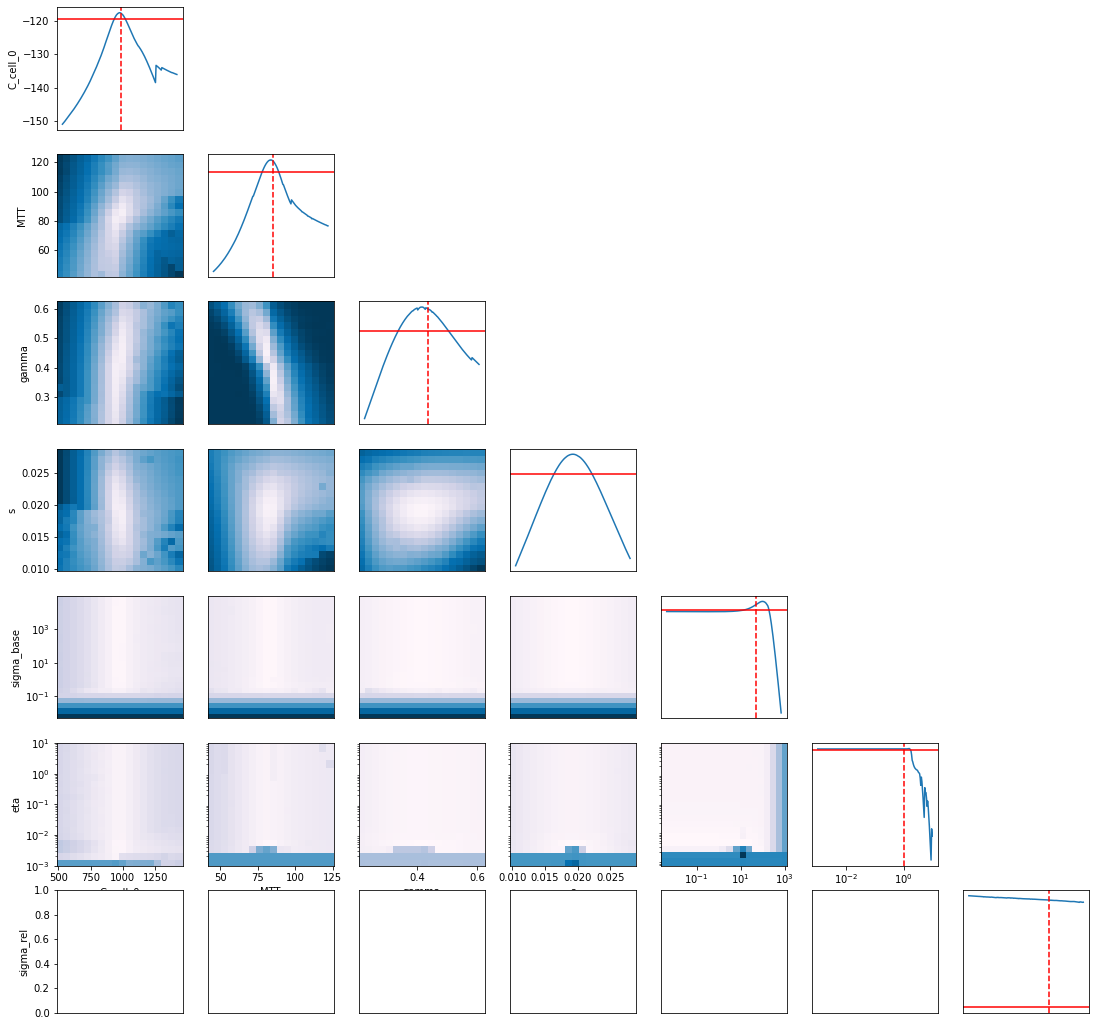

In [14]:
fig, ax = plt.subplots(7, 7)
fig.set_size_inches(18.5, 18.5)
for i in range(0,7):
    for j in range(0,7):
        if i == j:
            if i>3:
                likelihood = np.load("../Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+"_log_scale.npy")
                ax[i, j].set_xscale("log")
            else:
                likelihood = np.load("../Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")

            ax[i, j].plot(likelihood[:,0], likelihood[:,1])
            ax[i, j].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
                ax[i, j].axvline(x=PD_actual_params[i], linestyle='--', color='r')
        elif j<i:
            if i<6:
                if j<4:
                    likelihood, x_range, y_range = np.load(
                        "../Data_and_parameters/PD_sim/identify_comb_param_"
                        + str(i) + "_" + str(j) + ".npy",
                        allow_pickle=True
                    )
        #             y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
        #             x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)
                    colouring = ax[i, j].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
                
                else:
                    ident = np.load(
                        "../Data_and_parameters/PD_sim/identify_comb_param_"
                        + str(i) + "_" + str(j) + ".npz"
                    )
        #             y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
        #             x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)
                    colouring = ax[i, j].pcolormesh(
                        ident["x_range"], 
                        ident["y_range"], 
                        ident["likelihood"], 
                        vmin=ident["likelihood"].min(), 
                        vmax=ident["likelihood"].max(), 
                        cmap='PuBu_r', 
                        shading='auto'
                    )
                
                if i>3:
                    ax[i, j].set_yscale("log")
                if j>3:
                    ax[i, j].set_xscale("log")
            
    #             ax[i, j].axvline(x=PD_actual_params[j], linestyle='--', color='r')
    #             ax[i, j].axhline(y=PD_actual_params[i], linestyle='--', color='r')
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 5:
            ax[i, j].set_xlabel(PD_param_names[j])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel(PD_param_names[i])
        else:
            ax[i, j].set_yticks([])

<ipython-input-48-c2b7de31852c>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-48-c2b7de31852c>:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


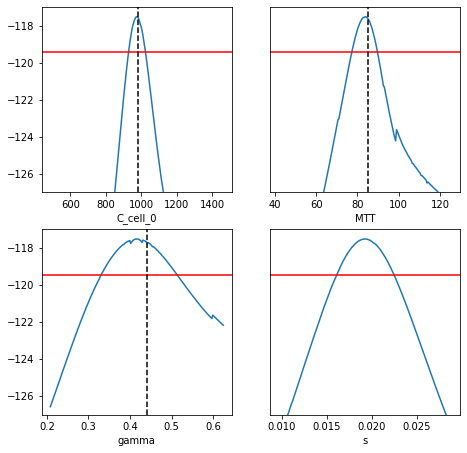

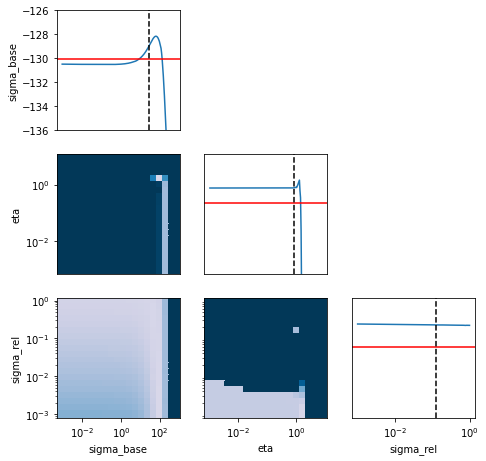

In [48]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7.5, 7.5)

#Mechanistic Parameters
for i in range(0,4):
    likelihood = np.load("../Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")
    ax[int(i/2), i%2].plot(likelihood[:,0], likelihood[:,1])
    ax[int(i/2), i%2].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
    if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
        ax[int(i/2), i%2].axvline(x=PD_actual_params[i], linestyle='--', color='black')
        
    ax[int(i/2), i%2].set_xlabel(PD_param_names[i])
    ax[int(i/2), i%2].set_ylim([-127, -117])
    if i%2==1:
        ax[int(i/2), i%2].set_yticks([])
        
fig.savefig(image_file + "sim_PD_params_ident.svg")
fig.show()

# Noise Parameters
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(7.5, 7.5)

for i in range(0,3):
    for j in range(0,3):
        if i == j:
            likelihood = np.load("../Data_and_parameters/PD_sim/identify_comb_param_"+str(i+4)+"_log_scale.npy")
            ax[i, j].set_xscale("log")

            ax[i, j].plot(likelihood[:,0], likelihood[:,1])
            ax[i, j].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
#             if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
            ax[i, j].axvline(x=PD_actual_params[i+4], linestyle='--', color='black')
            ax[i, j].set_ylim([-136, -126])
        elif j<i:
            ident = np.load(
                "../Data_and_parameters/PD_sim/identify_comb_param_"
                + str(i+4) + "_" + str(j+4) + ".npz"
            )
#             y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
#             x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)
            colouring = ax[i, j].pcolormesh(
                ident["x_range"], 
                ident["y_range"], 
                ident["likelihood"], 
                vmin= -136, # ident["likelihood"].max()-3.84, 
                vmax= -126, # ident["likelihood"].max(), 
                cmap='PuBu_r', 
                shading='auto'
            )

            ax[i, j].set_yscale("log")
            ax[i, j].set_xscale("log")
            
    #             ax[i, j].axvline(x=PD_actual_params[j], linestyle='--', color='r')
    #             ax[i, j].axhline(y=PD_actual_params[i], linestyle='--', color='r')
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 2:
            ax[i, j].set_xlabel(PD_param_names[j+4])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel(PD_param_names[i+4])
        else:
            ax[i, j].set_yticks([])

fig.savefig(image_file + "sim_noise_params_ident_pair.svg")
fig.show()

## Real Data

In [3]:
PD_param_names = ["Circ_0", "MTT", "gamma", "slope", "sigma_base", "eta", "sigma_rel"]

In [4]:
# Retrieve the PK parameters & PD data

PK_params=np.load("./Data_and_parameters/PK_real/opt_"+drug+"_"+str(dose)+".npy")[:4]
df = pandas.read_csv("./Data_and_parameters/PD_real/pd_real_data_refined_"+drug+"_dose_"+str(dose))
start_time = df['TIME'].min()
print(df)
dose_amount = df['dose_amount'][0]

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
print("approximate Circ_0: ", Circ_0_approx)

    Unnamed: 0   TIME  DOSE          OBS         std  dose_amount
0            2  -48.0  10.0   931.083333  122.426570     1.976778
1            6   24.0  10.0   773.750000  100.154464     1.976778
2           10   48.0  10.0   676.500000   69.173694     1.976778
3           14   72.0  10.0   711.750000  135.234056     1.976778
4           18   96.0  10.0   642.000000  119.635558     1.976778
5           22  120.0  10.0   808.000000   96.249675     1.976778
6           26  144.0  10.0   780.750000   90.973897     1.976778
7           30  168.0  10.0   711.250000  135.418795     1.976778
8           34  192.0  10.0   756.000000   51.961524     1.976778
9           38  216.0  10.0   997.500000  170.486559     1.976778
10          42  240.0  10.0  1122.500000  163.752863     1.976778
11          46  264.0  10.0  1570.333333  214.537487     1.976778
12          50  288.0  10.0  1092.500000  320.263954     1.976778
13          54  312.0  10.0  1443.666667  177.472064     1.976778
14        

In [11]:
opt_df = pandas.read_csv("./Data_and_parameters/PD_real/"+drug+"_"+str(dose)+"_opt_results.csv")

opt_point_comb = np.asarray(opt_df['Combined Noise'][1:-1])
opt_point_comb = opt_point_comb.astype('float64')

lower_bound = [0.1*Circ_0_approx, df['TIME'].max()*0.001, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*Circ_0_approx,      df['TIME'].max(),     5,    100,   Circ_0_approx,   10,    1]

print('Initial point for profile likelihood')
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(opt_point_comb[i]))

Initial point for profile likelihood
Circ_0 = 985.4348236774307
MTT = 84.41733865170596
gamma = 0.41193013945164614
slope = 16.561761985927035
sigma_base = 36.6956133152053
eta = 1.6684180862564724
sigma_rel = 0.0010000000000055982


In [39]:
algorithm = nlopt.LN_BOBYQA
num_param = len(opt_point_comb)-1
base_opt = nlopt.opt(algorithm, num_param)
base_opt.set_lower_bounds([0]*num_param)
unchanged_threshold = 1e-4
base_opt.set_ftol_abs(unchanged_threshold)
base_opt.set_xtol_rel(1e-4)
timer = pints.Timer()

def single_profile_loglikelihood(param_index, param_values, point_start):
    likelihood = []
    jump_points = []
    jump_hu = {}
    point = point_start
    previous_loglike = 0
    lb = base_opt.get_lower_bounds()
    ub = base_opt.get_upper_bounds()
    
    for i, x_i in enumerate(param_values):
        
        fix_noise = [None]*3

        if param_index < 4:
            fix_param=[[param_index], [x_i]]
        else:
            fix_param=[[], []]
            fix_noise[param_index-4] = x_i

        pints_model_simulated = PintsPDFriberg(
            PK_params, 
            dose_amount, 
            fix_param=fix_param, 
            start_time=start_time
        )
        problem = pints.SingleOutputProblem(
            pints_model_simulated, 
            df['TIME'].to_numpy()-start_time, 
            df['OBS'].to_numpy()
        )
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)
        
        def obj_func(x, grad):
            time_stamp = timer.time()
            print(
                "\r", 
                str(np.round((i/len(param_values)+n), 2)*50)
                + "% complete, time elapsed: "
                + str(int(time_stamp/60.0)) + " mins, "
                + str(time_stamp%60) + " secs.  ",
                sep=' ', 
                end='', 
                flush=True
            )
            return log_likelihood(x)
        
        opt = nlopt.opt(base_opt)
        opt.set_max_objective(obj_func)
        
        if any(point <= lb):
            for point_index in range(len(point)):
                point[point_index] = max(point[point_index], 1.0001*lb[point_index])
        if any(point >= ub):
            for point_index in range(len(point)):
                point[point_index] = min(point[point_index], 0.9999*ub[point_index])
                
        point = opt.optimize(point)
        loglike = opt.last_optimum_value()
        likelihood.append([x_i, loglike])
#         if abs(loglike - previous_loglike) > (3.84/2):
#             jump_points.append([x_i, point, loglike])
# #             jump_hu [x_i] = pints_model_simulated.hu
#         previous_loglike = loglike
#     if jump_points != []:
#         np.save(
#             "./Data_and_parameters/Debugging/identify_comb_jumps_param_"+str(param_index)+"_n_"+str(n), 
#             jump_points
#         )
#         np.save(
#             "./Data_and_parameters/Debugging/identify_comb_hus_param_"+str(param_index)+"_n_"+str(n), 
#             jump_hu
#         )
    return(likelihood)

In [40]:
# Mechanistic parameters

for param_index in range(0, 4): # upto param no. 4
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:]))
    base_opt.set_lower_bounds(lower_bound[:param_index] + lower_bound[param_index+1:])
    base_opt.set_upper_bounds(upper_bound[:param_index] + upper_bound[param_index+1:])
    
    timer.reset()
    
    n=0
    param_range = np.linspace(1*opt_point_comb[param_index], 0.5*opt_point_comb[param_index], 100)
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, point)
    
    n+=1
    param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
    likelihood_lower.reverse()
    likelihood = np.array(likelihood_lower+likelihood_upper)
    np.save("./Data_and_parameters/PD_real/identify_comb_param_"+str(param_index)+"_"+drug+"_dose_"+str(dose), likelihood)


 Profile likelihood for Circ_0:
 99.5% complete, time elapsed: 9 mins, 7.493453148985282 secs.     03 secs.    
 Profile likelihood for MTT:
 99.5% complete, time elapsed: 21 mins, 57.19651921186596 secs.     976 secs.    
 Profile likelihood for gamma:
 99.5% complete, time elapsed: 8 mins, 30.58665374200791 secs.      1 secs.    
 Profile likelihood for slope:
 99.5% complete, time elapsed: 17 mins, 58.71253097290173 secs.     463 secs.   

In [38]:
# Noise parameters
for param_index in range(4, 7): # param no. 4 to 7
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    # This should be done on a log scale across the prior
    
    point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:]))
    base_opt.set_lower_bounds(lower_bound[:param_index] + lower_bound[param_index+1:])
    base_opt.set_upper_bounds(upper_bound[:param_index] + upper_bound[param_index+1:])
    timer.reset()
    
    tot_evals = 200
    proportion = (
        np.log(opt_point_comb[param_index])-np.log(lower_bound[param_index])
    )/(
        np.log(upper_bound[param_index]) - np.log(lower_bound[param_index])
    )
    
    n=0
    param_range = np.logspace(np.log(opt_point_comb[param_index]), np.log(lower_bound[param_index]+0.01*opt_point_comb[param_index]), int(tot_evals*proportion), base = np.e)
    
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, point)
    
    n+=1
    param_range = np.logspace(np.log(opt_point_comb[param_index]), np.log(upper_bound[param_index]-0.01*opt_point_comb[param_index]), tot_evals-int(tot_evals*proportion), base = np.e)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
    likelihood_lower.reverse()
    likelihood = np.array(likelihood_lower+likelihood_upper)
    np.save("./Data_and_parameters/PD_real/identify_comb_param_"+str(param_index)+"_"+drug+"_dose_"+str(dose), likelihood)


 Profile likelihood for gamma:
 [9.75224694e+02 5.52000000e+02 1.00000003e-02][2.59323211e+02 1.10322805e+00 1.06351692e-03][9.75995409e+02 5.52000000e+02 1.00000000e-02][2.61474503e+02 5.33716041e-01 1.00247610e-03][9.75995409e+02 5.52000000e+02 1.00000000e-02][2.61474503e+02 5.33716041e-01 1.00247610e-03][9.75642226e+02 5.52000000e+02 1.00000000e-02][2.60948893e+02 9.05925355e-01 1.00125085e-03][9.75642226e+02 5.52000000e+02 1.00000000e-02][2.60948893e+02 9.05925355e-01 1.00237662e-03][9.75652641e+02 5.52000000e+02 1.00000000e-02][2.59667464e+02 1.08799387e+00 1.00000000e-03][9.75407944e+02 5.52000000e+02 1.00000000e-02][2.59421718e+02 1.10056652e+00 1.00000000e-03]
 Profile likelihood for slope:
 [1.07914598e+03 5.52000000e+02 1.42630083e-01][3.63460052e+02 1.00000117e-03 1.00000000e-03]
 Profile likelihood for sigma_base:
 [93.10833334 62.19050636  0.35553282][0.01000069 0.44844714 0.001     ]0000000e-03]0000e-03]
 Profile likelihood for eta:
 [93.10833576  0.55201138  1.46040844]

In [12]:
algorithm = nlopt.LN_BOBYQA
num_param = len(opt_point_comb)-2
base_opt = nlopt.opt(algorithm, num_param)
base_opt.set_lower_bounds([0]*num_param)
unchanged_threshold = 1e-4
base_opt.set_ftol_abs(unchanged_threshold)
timer = pints.Timer()

def pair_profile_likelihood(param_index_1, param_index_2, param_values_1, param_values_2, point_start):
    point_next_line = point_start
    likelihood_matrix = np.zeros((len(param_values_1), len(param_values_2)))
    
    for i, x_1 in enumerate(param_values_1):
        point = point_next_line
        
        for j, x_2 in enumerate(param_values_2):
            
            fix_mech = [[],[]]
            fix_noise = [None]*3
            if param_index_1<4:
                fix_mech[0].append(param_index_1)
                fix_mech[1].append(x_1)
            else: 
                fix_noise[param_index_1-4]=x_1
            if param_index_2<4:
                fix_mech[0].append(param_index_2)
                fix_mech[1].append(x_2)
            else: 
                fix_noise[param_index_2-4]=x_2
            
            pints_model = PintsPDFriberg(
                PK_params, 
                dose_amount,
                fix_param=fix_mech,
                start_time=start_time
            )
            problem = pints.SingleOutputProblem(
                pints_model, 
                df['TIME'].to_numpy()-start_time, 
                df['OBS'].to_numpy()
            )
            
            log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)  
            
            def obj_func(x, grad):
                time_stamp = timer.time()
                print(
                    "\r", 
                    str(np.round(((i+j/len(param_values_2))/len(param_values_1)+n)*25 , 2))
                    + "% complete, time elapsed: "
                    + str(int(time_stamp/60.0)) + " mins, "
                    + str(time_stamp%60) + " secs.  ",
                    sep=' ', 
                    end='', 
                    flush=True
                )
                return log_likelihood(x)
            
            opt = nlopt.opt(base_opt)
            opt.set_max_objective(obj_func)
            point = opt.optimize(point)
            loglike = opt.last_optimum_value()
            likelihood_matrix[i,j] = loglike
            
            if j==0:
                point_next_line = point
    return likelihood_matrix

In [34]:
# For double mechanistic parameters
for param_index_1 in range(0, 4):
    param_range_1_lower = np.linspace(1*opt_point_comb[param_index_1], 0.5*opt_point_comb[param_index_1], 10)
    param_range_1_upper = np.linspace(1*opt_point_comb[param_index_1], 1.5*opt_point_comb[param_index_1], 10)
    y_range = np.concatenate((param_range_1_lower[::-1], param_range_1_upper))
    
    for param_index_2 in range(0,param_index_1):
        print(
            "\n Pairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)

        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        x_range = np.concatenate((param_range_2_left[::-1], param_range_2_right))
    
        np.save(
            "./Data_and_parameters/PD_real/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2)+"_"+drug+"_dose_"+str(dose), 
            (likelihood, x_range, y_range)
        )


 Pairwise Profile likelihood for MTT and Circ_0:
 99.75% complete, time elapsed: 44 mins, 53.12578889541328 secs.     
 Pairwise Profile likelihood for gamma and Circ_0:
 99.75% complete, time elapsed: 41 mins, 9.959124773740768 secs.      3.5% complete, time elapsed: 21 mins, 0.9391837473958731 secs.  53.5% complete, time elapsed: 21 mins, 1.647967653349042 secs.  53.5% complete, time elapsed: 21 mins, 3.3527732752263546 secs.  53.5% complete, time elapsed: 21 mins, 3.7596287429332733 secs.  97.5% complete, time elapsed: 40 mins, 22.65530633740127 secs.  
 Pairwise Profile likelihood for gamma and MTT:
 31.75% complete, time elapsed: 12 mins, 18.407800221815705 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



 99.75% complete, time elapsed: 31 mins, 39.2566152960062 secs.       
 Pairwise Profile likelihood for slope and Circ_0:
 99.75% complete, time elapsed: 60 mins, 2.371432011947036 secs.      70.0% complete, time elapsed: 46 mins, 15.577834241092205 secs.  
 Pairwise Profile likelihood for slope and MTT:
 99.75% complete, time elapsed: 52 mins, 49.091498816385865 secs.     
 Pairwise Profile likelihood for slope and gamma:
 99.75% complete, time elapsed: 35 mins, 33.06585983373225 secs.     

In [ ]:
# For one mechanistic parameter and one noise parameter
for param_index_1 in range(5, 7):
    
    tot_evals = 20
    proportion_1 = (
        np.log(opt_point_comb[param_index_1])-np.log(lower_bound[param_index_1])
    )/(
        np.log(upper_bound[param_index_1]) - np.log(lower_bound[param_index_1])
    )
    
    param_range_1_lower = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(lower_bound[param_index_1]), 
        int(tot_evals*proportion_1), 
        base = np.e
    )
    param_range_1_upper = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(upper_bound[param_index_1]), 
        tot_evals-int(tot_evals*proportion_1), 
        base = np.e
    )
    y_range = np.concatenate((param_range_1_lower[::-1], param_range_1_upper))
    
    for param_index_2 in range(0, 4):
        print(
            "\n Pairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)

        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        x_range = np.concatenate((param_range_2_left[::-1], param_range_2_right))
    
        np.save(
            "./Data_and_parameters/PD_real/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2)+"_"+drug+"_dose_"+str(dose), 
            (likelihood, x_range, y_range)
        )


 Pairwise Profile likelihood for eta and Circ_0:
 2.81% complete, time elapsed: 4 mins, 34.693312994999815 secs.   

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 20.78% complete, time elapsed: 38 mins, 59.746334632999606 secs.   

In [ ]:
# For two noise parameters
for param_index_1 in range(4, 7):
    
    tot_evals = 20
    proportion_1 = (
        np.log(opt_point_comb[param_index_1])-np.log(lower_bound[param_index_1])
    )/(
        np.log(upper_bound[param_index_1]) - np.log(lower_bound[param_index_1])
    )
    
    param_range_1_lower = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(lower_bound[param_index_1]), 
        int(tot_evals*proportion_1), 
        base = np.e
    )
    param_range_1_upper = np.logspace(
        np.log(opt_point_comb[param_index_1]), 
        np.log(upper_bound[param_index_1]), 
        tot_evals-int(tot_evals*proportion_1), 
        base = np.e
    )
    y_range = np.concatenate((param_range_1_lower[::-1], param_range_1_upper[1:]))
    
    for param_index_2 in range(4, param_index_1):
        print(
            "\n Pairwise Profile likelihood for " + 
            PD_param_names[param_index_1] + 
            " and " + PD_param_names[param_index_2] + ":"
        )
        timer.reset()
        
        proportion_2 = (
            np.log(opt_point_comb[param_index_2])-np.log(lower_bound[param_index_2])
        )/(
            np.log(upper_bound[param_index_2]) - np.log(lower_bound[param_index_2])
        )

        param_range_2_left = np.logspace(
            np.log(opt_point_comb[param_index_2]), 
            np.log(lower_bound[param_index_2]), 
            int(tot_evals*proportion_2), 
            base = np.e
        )
        param_range_2_right = np.logspace(
            np.log(opt_point_comb[param_index_2]), 
            np.log(upper_bound[param_index_2]), 
            tot_evals-int(tot_evals*proportion_2), 
            base = np.e
        )
        
        point_start = np.concatenate((opt_point_comb[:param_index_2],
                                      opt_point_comb[param_index_2+1:param_index_1], 
                                      opt_point_comb[param_index_1+1:]
                                     ))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        x_range = np.concatenate((param_range_2_left[1::-1], param_range_2_right))
    
        np.save(
            "./Data_and_parameters/PD_real/identify_comb_param_"
            + str(param_index_1) + "_" + str(param_index_2)+"_"+drug+"_dose_"+str(dose), 
            (likelihood, x_range, y_range)
        )


 Pairwise Profile likelihood for eta and Circ_0:
 2.5% complete, time elapsed: 4 mins, 2.978206748000048 secs.     

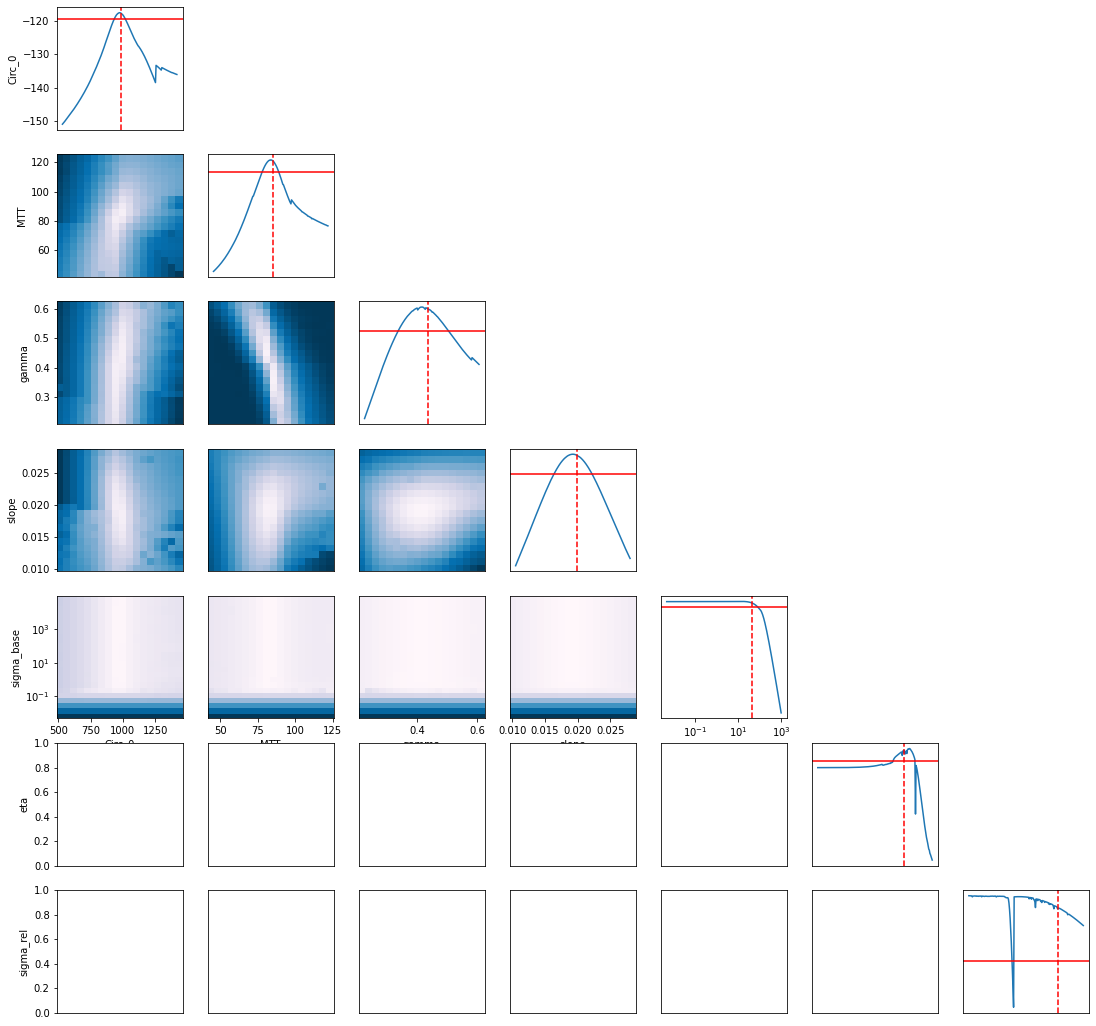

In [8]:
fig, ax = plt.subplots(7, 7)
fig.set_size_inches(18.5, 18.5)
for i in range(0,7):
    for j in range(0,7):
        if i == j:
                likelihood = np.load("./Data_and_parameters/PD_real/identify_comb_param_"+str(i)+"_"+drug+"_dose_"+str(dose)+".npy")
            if i>3:
                ax[i, j].set_xscale("log")

            ax[i, j].plot(likelihood[:,0], likelihood[:,1])
            ax[i, j].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
        elif j<i:
            likelihood, x_range, y_range = np.load(
                "./Data_and_parameters/PD_real/identify_comb_param_"
                + str(i) + "_" + str(j) +"_"+drug+"_dose_"+str(dose) + ".npy",
                allow_pickle=True
            )

            colouring = ax[i, j].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
            if i>3:
                ax[i, j].set_yscale("log")
            if j>3:
                ax[i, j].set_xscale("log")
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 7:
            ax[i, j].set_xlabel(PD_param_names[j])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel(PD_param_names[i])
        else:
            ax[i, j].set_yticks([])

In [ ]:
# Old Code

In [43]:
opt_df = pandas.read_csv("./Data_and_parameters/PD_real/opt_results.csv")
opt_point_comb = opt_df.loc[3,:].values[2:9]

lower_bound = [0.01*Circ_0_approx, df['TIME'].max()*0.01, 0.001, 0.001, 0.005, 0.001, 0.0001]
upper_bound = [100*Circ_0_approx, df['TIME'].max()*0.5, 5, 100, 1000, 10, 1]
print('Initial point for profile likelihood')
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(opt_point_comb[i]))

Initial point for profile likelihood
Circ_0 = 974.928581528346
MTT = 83.68306101500464
gamma = 0.4164428569194671
slope = 0.0192596079549873
sigma_base = 12.489882766574263
eta = 1.6381622423422335
sigma_rel = 0.0010000000001915


In [8]:
def single_profile_loglikelihood(param_index, param_values, point_start):
    likelihood = []
    point = point_start
    for i, x in enumerate(param_values):
        print("\r", str((i/len(param_values)+n)*50)+"% complete", sep=' ', end='', flush=True)
        fix_noise = [None]*3
        
        if param_index < 4:
            fix_param=[[param_index], [x]]
        else:
            fix_param=[[], []]
            fix_noise[param_index-4] = x
        
        pints_model_simulated = PintsPDFriberg(
            PK_params, 
            dose, 
            fix_param=fix_param, 
            start_time=start_time
        )
        problem = pints.SingleOutputProblem(
            pints_model_simulated, 
            df['TIME'].to_numpy()-start_time, 
            df['OBS'].to_numpy()
        )
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)
        error_measure = pints.ProbabilityBasedError(log_likelihood)
        unchanged_threshold = 1e-4
        
        optimisation = pints.OptimisationController(error_measure, point, method=pints.NelderMead)
        optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

        optimisation.set_log_to_screen(False)
        point, error = optimisation.run()
        likelihood.append([x, -error])
    return(likelihood)

In [48]:
for param_index in range(3, 4):
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:]))
    
    n=0
    param_range = np.linspace(1*opt_point_comb[param_index], 0.5*opt_point_comb[param_index], 100)
    likelihood_lower = single_profile_loglikelihood(param_index, param_range, point)
    
    n+=1
    param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
    likelihood_upper = single_profile_loglikelihood(param_index, param_range, point)
    
    likelihood_lower.reverse()
    likelihood = np.array(likelihood_lower+likelihood_upper)
    np.save("./Data_and_parameters/PD_sim/identify_comb_param_"+str(param_index), likelihood)


 Profile likelihood for slope:
[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.48100237e-12
 1.38470015e-01]
 0.0% complete

ValueError: Starting point must have same dimension as function to optimise.

In [13]:
def pair_profile_likelihood(param_index_1, param_index_2, param_values_1, param_values_2, point_start):
    point_next_line = point_start
    likelihood_matrix = np.zeros((len(param_values_1), len(param_values_2)))
    
    for i, x_1 in enumerate(param_values_1):
        print("\r", str(np.round((i/len(param_values_1)+n)*25, decimals=4))+"% complete", sep=' ', end='', flush=True)
        point = point_next_line
        
        for j, x_2 in enumerate(param_values_2):
            fix_mech = [[],[]]
            fix_noise = [None]*3
            if param_index_1<4:
                fix_mech[0].append(param_index_1)
                fix_mech[1].append(x_1)
            else: 
                fix_noise[param_index_1-4]=x_1
            if param_index_2<4:
                fix_mech[0].append(param_index_2)
                fix_mech[1].append(x_2)
            else: 
                fix_noise[param_index_2-4]=x_2
            
            pints_model = PintsPDFriberg(
                PK_params, dose,
                fix_param=fix_mech,
                start_time=start_time
            )
            problem = pints.SingleOutputProblem(
                pints_model, 
                df['TIME'].to_numpy()-start_time, 
                df['OBS'].to_numpy()
            )
            
            log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)  
            error_measure = pints.ProbabilityBasedError(log_likelihood)

            unchanged_threshold = 1e-4

            optimisation = pints.OptimisationController(error_measure, point, method=pints.NelderMead)
            optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

            optimisation.set_log_to_screen(False)
            point, error = optimisation.run()
            likelihood_matrix[i,j] = -error

            if j==0:
                point_next_line = point
    return likelihood_matrix

In [15]:
# For double parameters
for param_index_1 in range(0, 7):
    param_range_1_lower = np.linspace(1*opt_point_comb[param_index_1], 0.5*opt_point_comb[param_index_1], 10)
    param_range_1_upper = np.linspace(1*opt_point_comb[param_index_1], 1.5*opt_point_comb[param_index_1], 10)
    for param_index_2 in range(0,param_index_1):
        print("\n Pairwise Profile likelihood for " + PD_param_names[param_index_1] + " and " + PD_param_names[param_index_2] + ":")

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)

        point_start = np.concatenate((opt_point_comb[:param_index_2],opt_point_comb[param_index_2+1:param_index_1], opt_point_comb[param_index_1+1:]))
        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        np.save("./Data_and_parameters/PD_sim/identify_comb_param_"+str(param_index_1)+"_"+str(param_index_2)+"_dose_"+str(dose), likelihood)


 Pairwise Profile likelihood for MTT and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for gamma and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for gamma and MTT:
 12.5% complete

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Myelotoxicity_pkpd/Likelihoods.py:264: RuntimeWarning: invalid value encountered in true_divide
  0.5 * error**2 / (sigma_tot**2)


 97.5% complete
 Pairwise Profile likelihood for slope and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for slope and MTT:
 97.5% complete
 Pairwise Profile likelihood for slope and gamma:
 97.5% complete
 Pairwise Profile likelihood for sigma_base and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for sigma_base and MTT:
 97.5% complete
 Pairwise Profile likelihood for sigma_base and gamma:
 97.5% complete
 Pairwise Profile likelihood for sigma_base and slope:
 97.5% complete
 Pairwise Profile likelihood for eta and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for eta and MTT:
 97.5% complete
 Pairwise Profile likelihood for eta and gamma:
 97.5% complete
 Pairwise Profile likelihood for eta and slope:
 97.5% complete
 Pairwise Profile likelihood for eta and sigma_base:
 97.5% complete
 Pairwise Profile likelihood for sigma_rel and Circ_0:
 97.5% complete
 Pairwise Profile likelihood for sigma_rel and MTT:
 97.5% complete
 Pairwise Profile likelihood for sigma_re

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


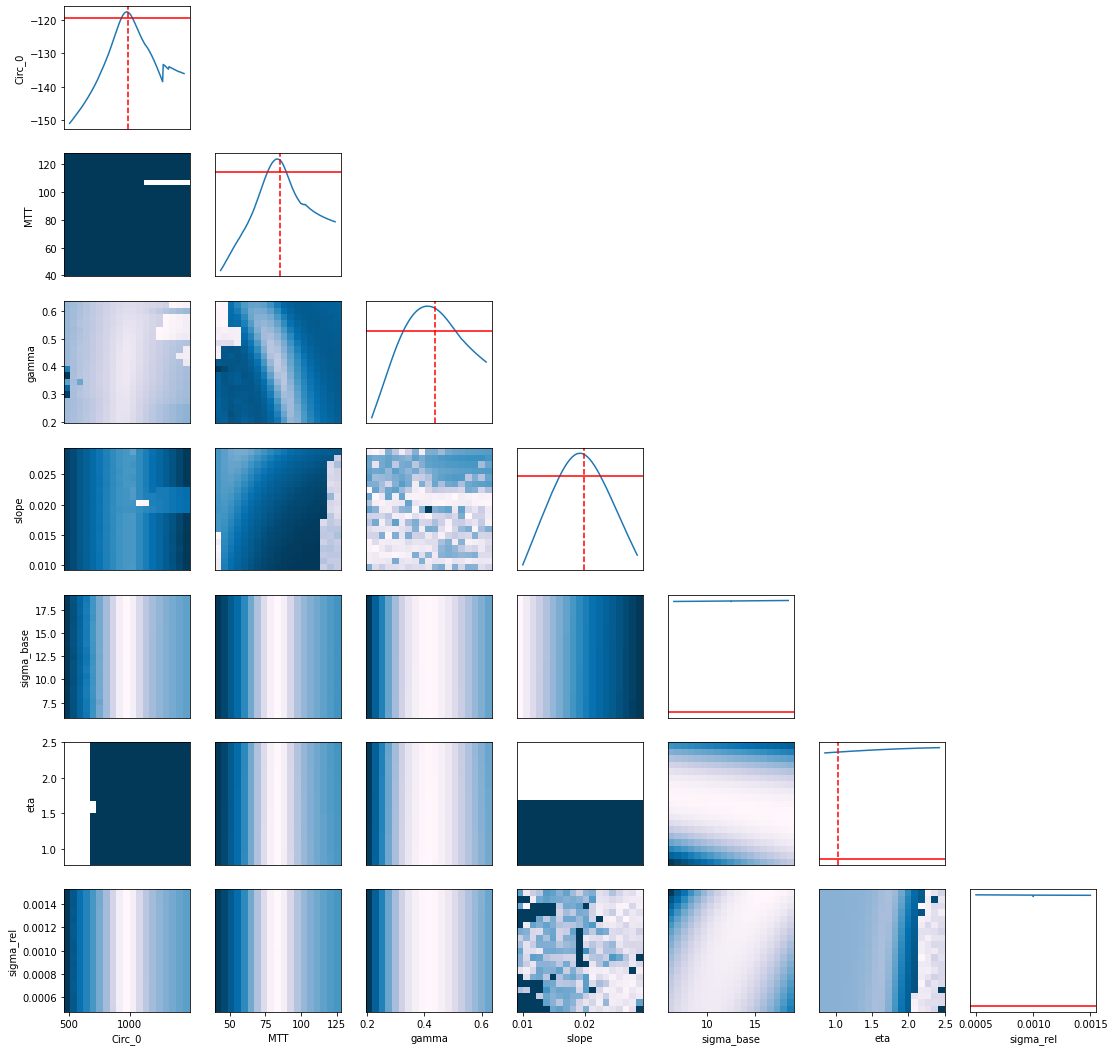

In [13]:
fig, ax = plt.subplots(7, 7)
fig.set_size_inches(18.5, 18.5)
for i in range(0,7):
    for j in range(0,7):
        if i == j:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")

            ax[i, j].plot(likelihood[:,0], likelihood[:,1])
            ax[i, j].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
                ax[i, j].axvline(x=PD_actual_params[i], linestyle='--', color='r')
        elif j<i:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+"_"+str(j)+"_dose_"+str(dose)+".npy")
            y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
            x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)

            colouring = ax[i, j].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
            
#             ax[i, j].axvline(x=PD_actual_params[j], linestyle='--', color='r')
#             ax[i, j].axhline(y=PD_actual_params[i], linestyle='--', color='r')
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 6:
            ax[i, j].set_xlabel(PD_param_names[j])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel(PD_param_names[i])
        else:
            ax[i, j].set_yticks([])

Circ_0 = 974.93, logL = -117.51, Noise params = [1.24898880e+01 1.63823942e+00 9.99635185e-04]
Circ_0 = 1285.13, logL = -133.3, Noise params = [1.33177435e-04 1.68741171e+00 1.55934472e-03]
Circ_0 = 974.93, logL = -117.51, Noise params = [1.24898828e+01 1.63816224e+00 1.00000000e-03]


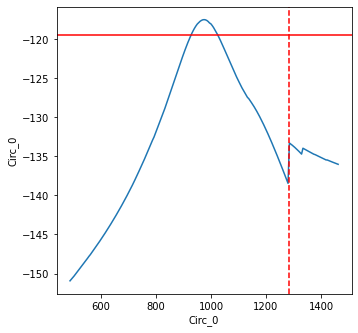

In [14]:
time_span = df["TIME"].max()
times = np.linspace(start_time,time_span,1000)

x_label = "Time, hours"
unit = ""
y_label = observation_name+ " concentration, " + unit

fig = px.scatter(
    df,
#     title="B",
    title= "B) Inference Results on Simulated Data",
    x="TIME",
    y="OBS",
    width=700, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
# fig.update_layout(yaxis_type="log")


fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Simulated Data'

jumps = np.concatenate((np.load(
            "./Data_and_parameters/Debugging/identify_comb_jumps_param_"+str(0)+"_n_"+str(0)+".npy", 
            allow_pickle = True
        )[1:] , np.load(
            "./Data_and_parameters/Debugging/identify_comb_jumps_param_"+str(0)+"_n_"+str(1)+".npy", 
            allow_pickle = True
        )))

# print(np.load(
#             "./Data_and_parameters/Debugging/identify_comb_jumps_param_"+str(0)+"_n_"+str(0)+".npy", 
#             allow_pickle = True
#         )[0,0:2])
# print(opt_point_comb)
# colour_scale = px.colors.qualitative.Plotly
# print(px.colors.convert_colorscale_to_rgb(colour_scale))

for i, entry in enumerate(jumps):
    x = entry[0]
    params = entry[1]
    fix_mech = [[0],[x]]
    PD_model_simulated = PintsPDFriberg(
                PK_params, 2,
                fix_param=fix_mech,
                start_time=start_time
            )
    likelihood = entry[2]
    y=PD_model_simulated.simulate(params[:-3], times-start_time)
    fig.add_trace(go.Scatter(
        x=times, 
        y=y,
        mode='lines',
        name='Circ_0 = ' + str(np.round(x, 2))
    ))
    print('Circ_0 = ' + str(np.round(x, 2))+', logL = ' + str(np.round(likelihood, 2))+', Noise params = ' + str(params[-3:]))
    if i == 1:
        noise_upper = y + (params[-3] + np.power(y, params[-2])*params[-1])
        noise_lower = y - (params[-3] + np.power(y, params[-2])*params[-1])
        noise = np.concatenate((noise_upper, noise_lower[::-1]))
    

        fig.add_trace(go.Scatter(
            x=np.concatenate((times, times[::-1])), # x, then x reversed
            y=noise, # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        ))



fix_noise = [None]*3
fix_param=[[0], [opt_point_comb[0]]]

PD_model_simulated = PintsPDFriberg(
    PK_params, 
    2, 
    fix_param=fix_param, 
    start_time=start_time
)
problem = pints.SingleOutputProblem(
    PD_model_simulated, 
    df['TIME'].to_numpy()-start_time, 
    df['OBS'].to_numpy()
)
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_noise)
error_measure = pints.ProbabilityBasedError(log_likelihood)
fig.add_trace(go.Scatter(
    x=times, 
    y=PD_model_simulated.simulate(opt_point_comb[1:-3], times-start_time),
    mode='lines',
    name='Circ_0 = ' + str(np.round(opt_point_comb[0], 2))
))
print('Circ_0 = ' + str(np.round(opt_point_comb[0], 2))+', logL = ' + str(np.round(-error_measure(opt_point_comb[1:]), 2))+', Noise params = ' + str(opt_point_comb[-3:]))
    
PD_model_simulated = PintsPDFriberg(
            PK_params, 2,
            start_time=start_time
        )
fig.add_trace(go.Scatter(
    x=times, 
    y=PD_model_simulated.simulate(opt_point_comb[:-3], times-start_time),
    mode='lines',
    name='Circ_0 = ' + str(np.round(opt_point_comb[0], 2))
))
# image_name = "./Images/" + "simulation"
# fig.write_image(image_name + "_PD_dose_" + str(dose) + "_opt.svg")
fig.show()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5/3.5, 18.5/3.5)
for i in range(0,1):
    for j in range(0,1):
        if i == j:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")

            ax.plot(likelihood[:,0], likelihood[:,1])
            ax.axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            for entry in jumps[1:]:
                x = entry[0]
                ax.axvline(x=x, linestyle='--', color='r')
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        ax.set_xlabel(PD_param_names[j])
        ax.set_ylabel(PD_param_names[i])

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


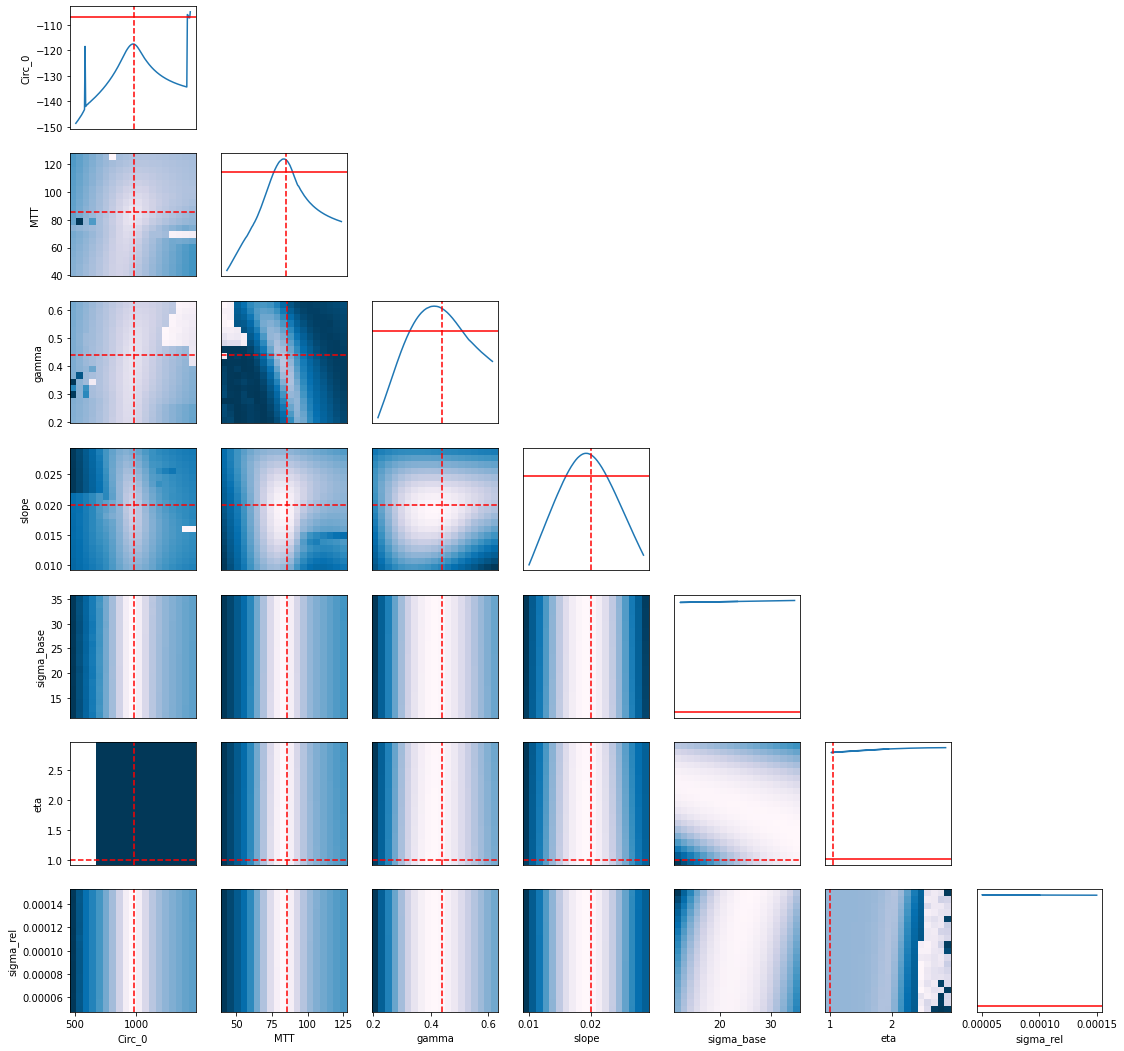

In [17]:
fig, ax = plt.subplots(7, 7)
fig.set_size_inches(18.5, 18.5)
opt_point_comb = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(2)+".npy", allow_pickle=True)[0]
for i in range(0,7):
    for j in range(0,7):
        if i == j:
            likelihood = np.load("./Data_and_parameters/pd_sim_identify_comb_param_"+str(i)+"_dose_"+str(2)+".npy")
            # likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")

            ax[i, j].plot(likelihood[:,0], -likelihood[:,1])
            ax[i, j].axhline(y=np.max(-likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
                ax[i, j].axvline(x=PD_actual_params[i], linestyle='--', color='r')
        elif j<i:
#             likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+"_"+str(j)+"_dose_"+str(dose)+".npy")
            likelihood = -np.load("./Data_and_parameters/pd_sim_identify_comb_param_"+str(i)+"_"+str(j)+"_dose_"+str(2)+".npy")
            
            y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
            x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)

            colouring = ax[i, j].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
            
            if (PD_actual_params[j]<np.max(x_range) and PD_actual_params[j]>np.min(x_range)):
                ax[i, j].axvline(x=PD_actual_params[j], linestyle='--', color='r')
            if (PD_actual_params[i]<np.max(y_range) and PD_actual_params[i]>np.min(y_range)):
                ax[i, j].axhline(y=PD_actual_params[i], linestyle='--', color='r')
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 6:
            ax[i, j].set_xlabel(PD_param_names[j])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel(PD_param_names[i])
        else:
            ax[i, j].set_yticks([])

image_name = "./Images/" + "PD_sim"
fig.savefig(image_name + "_comb_param_identifiability.svg")

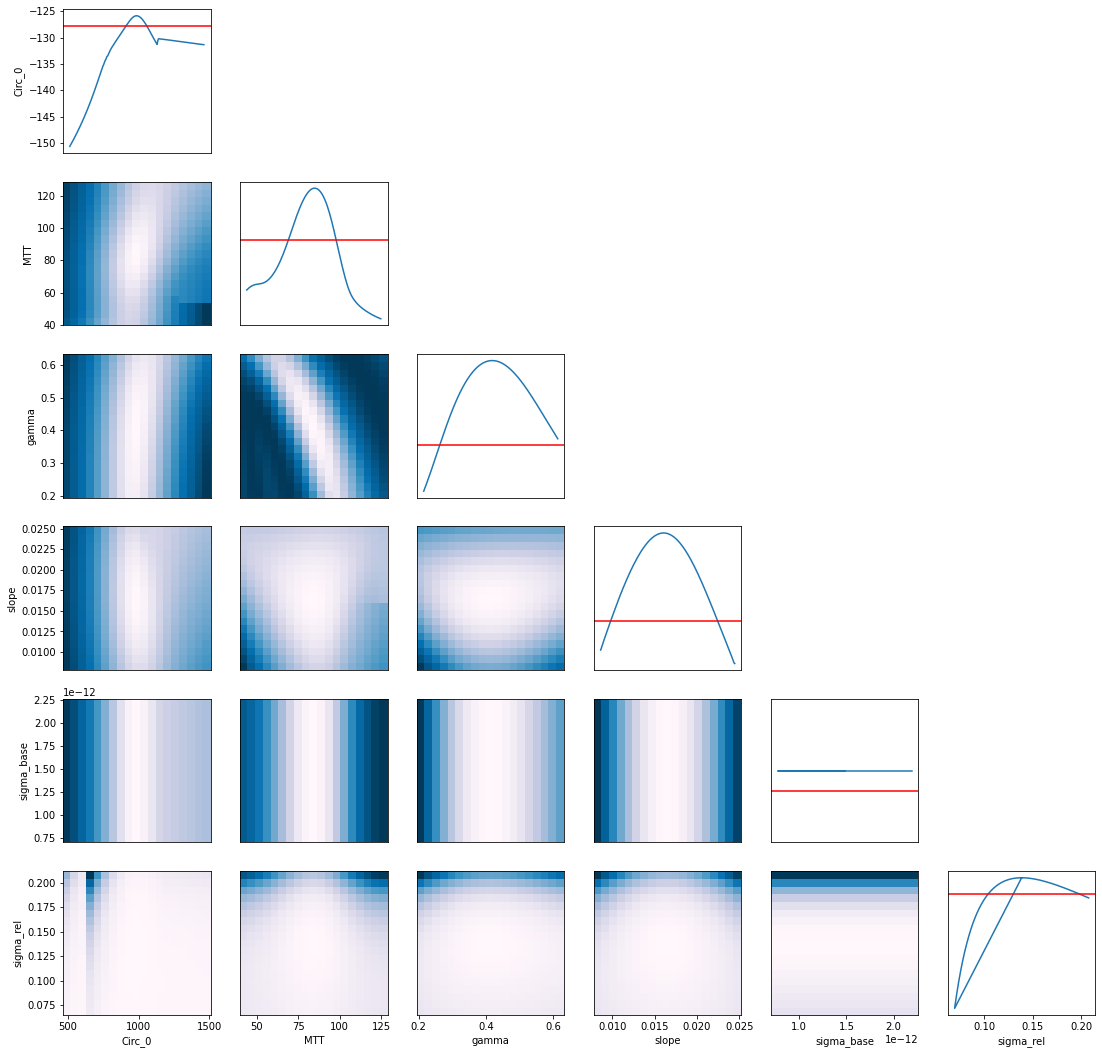

In [16]:
fig, ax = plt.subplots(6, 6)
fig.set_size_inches(18.5, 18.5)
opt_point_comb = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(int(dose))+".npy", allow_pickle=True)
for i in range(0,6):
    for j in range(0,6):
        if i == j:
            likelihood = np.load("./Data_and_parameters/pd_real_identify_combNoEta_param_"+str(i)+"_dose_"+str(int(dose))+".npy")
            # likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+".npy")

            ax[i, j].plot(likelihood[:,0], -likelihood[:,1])
            ax[i, j].axhline(y=np.max(-likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            
        elif j<i:
#             likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_param_"+str(i)+"_"+str(j)+"_dose_"+str(dose)+".npy")
            likelihood = -np.load("./Data_and_parameters/pd_real_identify_comb_param_"+str(i)+"_"+str(j)+"_dose_"+str(int(dose))+".npy")
            
            y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
            x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)

            colouring = ax[i, j].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
        
        else:
            ax[i, j].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if i == 5:
            ax[i, j].set_xlabel((PD_param_names[:5]+PD_param_names[6:])[j])
        else:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel((PD_param_names[:5]+PD_param_names[6:])[i])
        else:
            ax[i, j].set_yticks([])

image_name = "./Images/" + "PD_real"
fig.savefig(image_name + "_comb_param_identifiability.svg")